In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
import warnings
from transformers import logging as hf_logging
from tqdm import tqdm 

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [3]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [4]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [5]:
df["label"].value_counts()

Outro          8385
Entrega        4819
Produto        2961
Atendimento    1944
Name: label, dtype: int64

In [6]:
df["label"].value_counts(normalize=True)

Outro          0.463029
Entrega        0.266111
Produto        0.163510
Atendimento    0.107350
Name: label, dtype: float64

In [7]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


df["tweets"] = df["tweets"].apply(cleanTxt)
df["tweets"] = df["tweets"].apply(removeEmojis)
df["tweets"] = df["tweets"].apply(removeStopWords)

In [8]:
#Verificando novamente se houve tweets nulos após tratamento
df["tweets"].isnull().sum()

0

In [9]:
le = LabelEncoder()
df['label_num'] = le.fit_transform(df["label"])

In [10]:
label_dict = (df[['label','label_num']].drop_duplicates()
              .sort_values(by='label_num')
              .reset_index(drop=True)['label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Atendimento
1 Entrega
2 Outro
3 Produto


In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [12]:
# Splitting the data

# 30% of the training data as validation data

num_train_samples = int(train_df.shape[0] * 0.7)

x_train = train_df['tweets'][:num_train_samples]
y_train = train_df['label_num'][:num_train_samples]
x_val = train_df['tweets'][num_train_samples:]
y_val = train_df['label_num'][num_train_samples:]


### Checking
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

8873 training examples
3803 validation examples


In [13]:
x_test = test_df['tweets']
y_test = test_df['label_num']
print(f"{len(x_test)} testing examples")

5433 testing examples


In [14]:
MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

In [15]:
# Finding the max token sequence in the training set

max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 124


In [16]:
# I will set the max length and input for the deep learning model to 126
# (Max token length + 2 for special characters [CLS] and [SEP])

MAX_LENGTH = max_val + 2

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [17]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|██████████| 3803/3803 [00:01<00:00, 2188.98it/s]


In [31]:
# Looking at entry

index_num = 4

print(train_df.loc[index_num]['label'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

Atendimento 

faz péss atend relaç ped diz tod entreg gat precis are agor nada! 

ID's	Input Tokens
101	[CLS]
175	f
10961	##az
185	p
10051	##és
1116	##s
8756	ate
3276	##nd
1231	re
1742	##la
28201	##ç
185	p
1174	##ed
4267	di
1584	##z
1106	to
1181	##d
4035	en
7877	##tre
1403	##g
176	g
2980	##at
3073	pre
21349	##cis
1132	are
2403	ago
1197	##r
9468	na
1810	##da
106	!
102	[SEP]


In [19]:
# Creating the model

config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(4, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 126)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 126)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']    

In [20]:
# Creating a output directory to store the models weights

output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [21]:
# Callbacks

model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=2, # Stop after 2 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [22]:
# Compile and Train

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
555/555 [==============================] - 3437s 6s/step - loss: 0.7679 - accuracy: 0.7117 - val_loss: 0.6038 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 2/10
555/555 [==============================] - 3412s 6s/step - loss: 0.5796 - accuracy: 0.7933 - val_loss: 0.5456 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 3/10
555/555 [==============================] - 2685s 5s/step - loss: 0.5122 - accuracy: 0.8129 - val_loss: 0.5319 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 4/10
555/555 [==============================] - 2521s 5s/step - loss: 0.4769 - accuracy: 0.8262 - val_loss: 0.5216 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 5/10
555/555 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8371
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
555/555 [==============================] - 2549s 5s/step - loss: 0.4444 - accuracy: 0.8371 - val_loss: 0.5237 - val_accuracy: 0.8088 - lr: 0.0010
Epoch 6/10
555/555 [==============================] -

Lowest Validation Loss: epoch 6
Highest Validation Accuracy: epoch 6


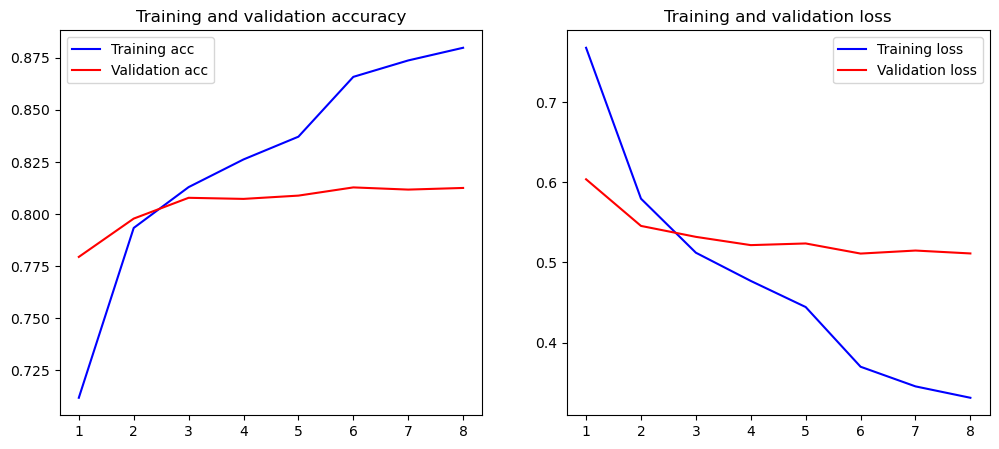

In [23]:
# Plotting the training accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [24]:
# Loading the model with the best validation accuracy

def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [25]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

In [26]:
# Making inference on the test data
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

170/170 [==============================] - 873s 5s/step


In [27]:
labels_4 = ['Atendimento','Entrega','Outro','Produto'] 

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_4,columns=[0,1,2,3]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3], labels_4, rotation=45)
    plt.ylabel("True Value")
    plt.show()

Accuracy: 0.8170439904288607


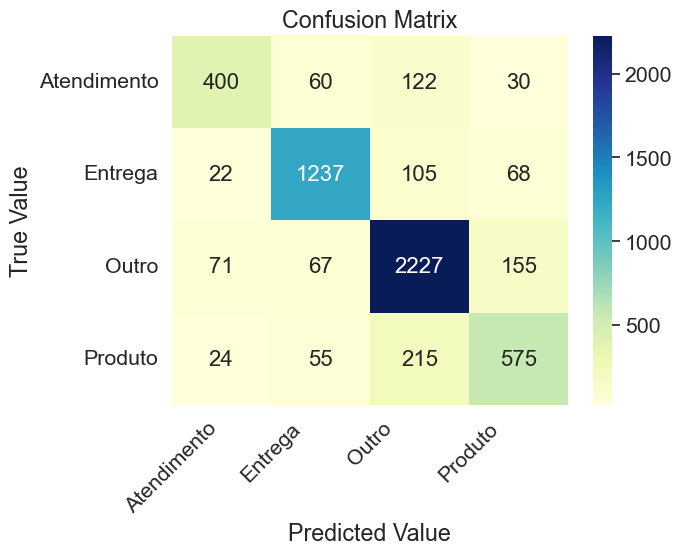

In [28]:
# Results

print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [29]:
print(classification_report(y_test, y_hat, target_names=labels_4))

              precision    recall  f1-score   support

 Atendimento       0.77      0.65      0.71       612
     Entrega       0.87      0.86      0.87      1432
       Outro       0.83      0.88      0.86      2520
     Produto       0.69      0.66      0.68       869

    accuracy                           0.82      5433
   macro avg       0.79      0.77      0.78      5433
weighted avg       0.82      0.82      0.82      5433

